# Pytorch Demo 



## 1. Import packages

In [1]:
import os
import time
import logging
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt # 基础数据处理

from random import sample # 随机采样

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader # Pytorch
print(torch.__version__)

import torchvision
import torchvision.transforms as transforms
# import scipy # if ImageNet

from tqdm.notebook import tnrange
from tqdm.notebook import tqdm
import time

# Code in './models'
# TODO: Read it
import models
model_Names = sorted(name for name in models.__dict__ 
                     if name.islower() and not name.startswith('__') 
                     and callable(models.__dict__[name])) # find all predifined models
print(model_Names)

# Code in './utils'
# TODO: Read them
from utils.log import setup_logging, ResultsLog, save_checkpoint, export_args_namespace
from utils.optim import OptimRegime
from utils.cross_entropy import CrossEntropyLoss
from utils.misc import torch_dtypes
from utils.param_filter import FilterModules, is_bn

1.4.0
['alexnet', 'densenet', 'googlenet', 'inception_v2', 'mobilenet', 'vgg']


# 2. Confirm Hyper-paramters & Log

In [7]:
dataName = 'ImageNet' 
modelName = 'vgg'
depth = '19' # for vgg
resultsDir = './results'
saveDir = 'vggCifar10' # log and model are saved in resultsDir/saveDir
resume = '' # path to the latest checkpoint
evaluate = None # evaluate model FILE on validation set
startEpoch = 0 # manual epoch number (useful on restarts). Defult start at 0)
batchSize = 16
evalBatchSize = -1 # 'mini-batch size (default: same as training)'

seed = 12450 # Random seed
inputSize = 224 # image input size
device = "cuda" if torch.cuda.is_available() else "cpu"
deviceIds = None if (device == 'cpu') else '1,2'
numWorkers = 8
epochs = 90


optimizer = 'SGD'
global lr = 0.1 # initial learning rate
momentum = 0.9 
weightDecay = 0 # l2 norm
printFreq = 50 # print frequency



'''
SWITCH
'''
dropOptimState = False # do not save optimizer state for resume
saveAll = False # save checkpoint for every epoch

'''
Todo Tricks 
'''
labelSmoothing = 0 # label smoothing coefficient - default 0
syncBN = False # synchronize batch normalization 多卡同步BN
mixUp = None # mixip alpha cofficient
cutMix = None # cutmox alpha coefficient
duplicates = 1 #number of augmentations over singel example
chunkBatch = 1 # chunk batch size for multiple passes (training)
cutOut = False # cut out augumentations
autoAugment = False # use autoaugment policies'
gradClip = -1 # maximum grad norm value, -1 for none
lossScale = 1 # loss scale for mixed precision training
adaptGradNorm = None # adapt gradient scale frequency (default: None)

'''
TODO Features
'''
configName = None # TODO: Add Json config file or others for fast setting up
dtype = None # TODO: Further quantization
distributed = False # TODO: Further distibuted data parallel
worldSize = -1 
localRank = -1
distInit = 'env://'
distBackend = 'ncll'
tensorWatch = False # Set tensorwatch logging
tensorWatchPort = 0 # set tensorwatch port





save_path = os.path.join(resultsDir, saveDir)
if not os.path.exists(save_path):
    os.makedirs(save_path)

setup_logging(os.path.join(save_path, 'log.txt'),
              resume = resume != '',
              dummy = False)# TODO: dummy is for distributed training 
logging.info('FIXME: Hyperdash can\'t work on python 3.8')
results_path = os.path.join(save_path, 'resluts')
results = ResultsLog(results_path, title= 'Train Results -%s' % saveDir)
logging.info('saving to %s', save_path)



SyntaxError: invalid syntax (<ipython-input-7-ae18ac2edb21>, line 21)

## 3. Dataset
All datasets are saved in `'../dataset/'`
For MNIST, CIFAR10 and CIFAR100, you can download it by setting `download=True` in `torchvision.datasets.XXXX`.

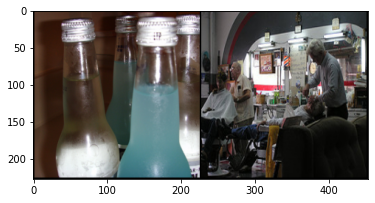

In [3]:
# Test the tqdm
# for i in tnrange(2, desc='1st loop'):
#     for j in tnrange(50,desc='2nd loop'):
#         time.sleep(0.01)

train_trainsform = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=2),
                                       transforms.ToTensor()])
val_trainsform = train_trainsform
def get_TrainVal_dataset(dataName,trian_transform,val_transform):
    if dataName == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(
            root='../dataset/',
            train=True,
            transform=trian_transform,
            download=False
        )
        val_dataset = torchvision.datasets.MNIST(
            root='../dataset/',
            train=False,
            transform=val_transform,
            download=False
        )
        return train_dataset, val_dataset
    elif dataName == 'CIFAR10':
        train_dataset = torchvision.datasets.CIFAR10(
            root='../dataset/cifar10',
            train=True,
            transform=trian_transform,
            download=False
        )
        val_dataset = torchvision.datasets.CIFAR10(
                root='../dataset/cifar10',
                train=False,
                transform=val_transform,
                download=False
        )
        return train_dataset, val_dataset
    elif dataName =='CIFAR100':
        train_dataset = torchvision.datasets.CIFAR100(
            root='/data/datasets/',
            train=True,
            transform=trian_transform,
            download=False
        )
        val_dataset = torchvision.datasets.CIFAR100(
            root='/data/datasets/',
            train=False,
            transform=val_transform,
            download=False
        )
        return train_dataset, val_dataset
    elif dataName == 'ImageNet':
        train_dataset = torchvision.datasets.ImageFolder(
            root = '../dataset/ImageNet/train',
            transform = trian_transform,
        )
        val_dataset = torchvision.datasets.ImageFolder(
            root = '../dataset/ImageNet/val',
            transform = val_transform,
        )
        return train_dataset, val_dataset
    else:
        msg = ("Wrong dataset name, choose one from \'MNIST\', \'CIFAR10\', \'CIFAR100\' and \'ImageNet\'!")
        raise RuntimeError(msg)



trainset, valset = get_TrainVal_dataset(dataName,train_trainsform,val_trainsform)

# Image Visualization
dl = DataLoader(trainset, batch_size = 2, shuffle = True, num_workers = 8) 

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(dl)
images,labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
del dl

# 4. Model Initializing 

In [17]:
logging.info("creating model %s", modelName)

if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
    cudnn.benchmark = True
    os.environ["CUDA_VISIBLE_DEVICES"] = deviceIds
else:
    dviceIds = None

# create model
model = models.__dict__[modelName]
model_config = {'depth':19, 'dataset': dataName}

model = model(**model_config)
num_parameters = sum([l.nelement() for l in model.parameters()])
logging.info("number of parameters: %d", num_parameters)

#TODO main.py line 196~230 Resume & Evaluation code

# Loss function(criterion) definition
loss_params = {}
if labelSmoothing>0:
    loss_params['smooth_eps'] = labelSmoothing
criterion = getattr(model,'criterion',CrossEntropyLoss)(**loss_params)

criterion.to(device)
model.to(device)

if distributed:
    model = nn.parallel.DistributedDataParallel(model,
                                                device_ids=deviceIds,
                                                output_device=device_ids[0])
elif deviceIds and len(deviceIds) > 1:
    model = nn.DataParallel(model)
else:
    model = model

# Optimizer configuration
optim_regime = getattr(model, 'regime', [{'epoch': 0,
                                          'optimizer': optimizer,
                                          'lr': lr,
                                          'momentum': momentum,
                                          'weight_decay': weightDecay}])
optimizer = OptimRegime(model, optim_regime)


creating model vgg
number of parameters: 38958922


In [14]:
print(optimizer)

[{'epoch': 0, 'optimizer': 'SGD', 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0}]


# 5. Training

In [11]:
# Function before training~

def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()

        input_var = torch.autograd.Variable(input.cuda())
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)
        #pdb.set_trace()
        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target.data, topk=(1, 5))
        losses.update(loss.data, input.size(0))
        top1.update(prec1, input.size(0))
        top5.update(prec5, input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % printFreq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1, top5=top5))


def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda()
        input_var = torch.autograd.Variable(input.cuda(), volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        with torch.no_grad():
             output = model(input_var)
             loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data, input.size(0))
        top1.update(prec1, input.size(0))
        top5.update(prec5, input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % printFreq == 0:
            logging.info('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg





class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(lr, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [24]:
train_trainsform = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=2),
                                       transforms.RandomAffine((-15,15), translate=(0.1,0.3),shear=(-5,5), fillcolor=0),
                                       transforms.RandomHorizontalFlip(p=0.3), # 30% 概率水平翻转
                                       transforms.RandomRotation((-10,10)), # 随机旋转
                                       torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=0.3, interpolation=3),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])
val_trainsform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

trainset, valset = get_TrainVal_dataset(dataName,train_trainsform,val_trainsform)
train_loader = DataLoader(trainset, batch_size = batchSize, shuffle = True, pin_memory = True, num_workers = 8) 
val_loader = DataLoader(valset, batch_size = batchSize, shuffle = False, pin_memory = True, num_workers = 8)




In [25]:
# FIXME
print('Some bugs occur in adjust learning rate and optimizer')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=5e-06)


for epoch in range(startEpoch, epochs):
#     adjust_learning_rate(lr, optimizer, epoch)
    
    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    prec1 = validate(val_loader, model, criterion)
    scheduler.step(prec1)
    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
                     'epoch': epoch + 1,
                     'arch': 'my',
                     'state_dict': model.state_dict(),
                     'best_prec1': best_prec1,
                     'optimizer' : optimizer.state_dict(),
                     }, is_best)

Some bugs occur in adjust learning rate and optimizer


RuntimeError: CUDA error: out of memory (malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:260)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x33 (0x7fad10a3b193 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1ba1a (0x7fad10c7ca1a in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1cd5e (0x7fad10c7dd5e in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #3: THCStorage_resize + 0xa3 (0x7fad155396f3 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #4: at::native::empty_strided_cuda(c10::ArrayRef<long>, c10::ArrayRef<long>, c10::TensorOptions const&) + 0x636 (0x7fad16b07856 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #5: <unknown function> + 0x45bcd2a (0x7fad1544ad2a in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #6: <unknown function> + 0x1f4fc81 (0x7fad12dddc81 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #7: <unknown function> + 0x3aadfb0 (0x7fad1493bfb0 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #8: <unknown function> + 0x1f4fc81 (0x7fad12dddc81 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #9: <unknown function> + 0x1cb869e (0x7fad12b4669e in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #10: at::native::to(at::Tensor const&, c10::TensorOptions const&, bool, bool, c10::optional<c10::MemoryFormat>) + 0x245 (0x7fad12b476f5 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #11: <unknown function> + 0x1ffdb9a (0x7fad12e8bb9a in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #12: <unknown function> + 0x3ce3866 (0x7fad14b71866 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #13: <unknown function> + 0x20485e2 (0x7fad12ed65e2 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #14: torch::cuda::scatter(at::Tensor const&, c10::ArrayRef<long>, c10::optional<std::vector<long, std::allocator<long> > > const&, long, c10::optional<std::vector<c10::optional<c10::cuda::CUDAStream>, std::allocator<c10::optional<c10::cuda::CUDAStream> > > > const&) + 0x710 (0x7fad15844f60 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch.so)
frame #15: <unknown function> + 0x9c5dcf (0x7fad5bdf4dcf in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #16: <unknown function> + 0x295928 (0x7fad5b6c4928 in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #17: PyCFunction_Call + 0x56 (0x563574933c06 in /home/liuchang/.conda/envs/torch/bin/python)
frame #18: _PyObject_MakeTpCall + 0x21f (0x5635748f599f in /home/liuchang/.conda/envs/torch/bin/python)
frame #19: _PyEval_EvalFrameDefault + 0x537f (0x563574997b2f in /home/liuchang/.conda/envs/torch/bin/python)
frame #20: _PyEval_EvalCodeWithName + 0x2e4 (0x56357493f5f4 in /home/liuchang/.conda/envs/torch/bin/python)
frame #21: _PyFunction_Vectorcall + 0x1c5 (0x5635749404d5 in /home/liuchang/.conda/envs/torch/bin/python)
frame #22: _PyEval_EvalFrameDefault + 0x4e09 (0x5635749975b9 in /home/liuchang/.conda/envs/torch/bin/python)
frame #23: _PyFunction_Vectorcall + 0xfb (0x56357494040b in /home/liuchang/.conda/envs/torch/bin/python)
frame #24: PyVectorcall_Call + 0x6f (0x5635748f520f in /home/liuchang/.conda/envs/torch/bin/python)
frame #25: THPFunction_apply(_object*, _object*) + 0xaff (0x7fad5ba93f3f in /home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #26: PyCFunction_Call + 0xdb (0x563574933c8b in /home/liuchang/.conda/envs/torch/bin/python)
frame #27: _PyObject_MakeTpCall + 0x21f (0x5635748f599f in /home/liuchang/.conda/envs/torch/bin/python)
frame #28: _PyEval_EvalFrameDefault + 0x537f (0x563574997b2f in /home/liuchang/.conda/envs/torch/bin/python)
frame #29: _PyEval_EvalCodeWithName + 0x961 (0x56357493fc71 in /home/liuchang/.conda/envs/torch/bin/python)
frame #30: _PyFunction_Vectorcall + 0x21e (0x56357494052e in /home/liuchang/.conda/envs/torch/bin/python)
frame #31: <unknown function> + 0x1845f6 (0x5635749335f6 in /home/liuchang/.conda/envs/torch/bin/python)
frame #32: PyIter_Next + 0xe (0x5635748f758e in /home/liuchang/.conda/envs/torch/bin/python)
frame #33: PySequence_Tuple + 0xfb (0x56357493e93b in /home/liuchang/.conda/envs/torch/bin/python)
frame #34: _PyEval_EvalFrameDefault + 0x5ddd (0x56357499858d in /home/liuchang/.conda/envs/torch/bin/python)
frame #35: _PyEval_EvalCodeWithName + 0x961 (0x56357493fc71 in /home/liuchang/.conda/envs/torch/bin/python)
frame #36: _PyFunction_Vectorcall + 0x21e (0x56357494052e in /home/liuchang/.conda/envs/torch/bin/python)
frame #37: _PyEval_EvalFrameDefault + 0x6e1 (0x563574992e91 in /home/liuchang/.conda/envs/torch/bin/python)
frame #38: _PyEval_EvalCodeWithName + 0x961 (0x56357493fc71 in /home/liuchang/.conda/envs/torch/bin/python)
frame #39: _PyFunction_Vectorcall + 0x21e (0x56357494052e in /home/liuchang/.conda/envs/torch/bin/python)
frame #40: _PyEval_EvalFrameDefault + 0x6e1 (0x563574992e91 in /home/liuchang/.conda/envs/torch/bin/python)
frame #41: _PyEval_EvalCodeWithName + 0x2e4 (0x56357493f5f4 in /home/liuchang/.conda/envs/torch/bin/python)
frame #42: _PyFunction_Vectorcall + 0x268 (0x563574940578 in /home/liuchang/.conda/envs/torch/bin/python)
frame #43: _PyEval_EvalFrameDefault + 0x1451 (0x563574993c01 in /home/liuchang/.conda/envs/torch/bin/python)
frame #44: _PyFunction_Vectorcall + 0xfb (0x56357494040b in /home/liuchang/.conda/envs/torch/bin/python)
frame #45: <unknown function> + 0x16de75 (0x56357491ce75 in /home/liuchang/.conda/envs/torch/bin/python)
frame #46: _PyEval_EvalFrameDefault + 0x4e09 (0x5635749975b9 in /home/liuchang/.conda/envs/torch/bin/python)
frame #47: _PyEval_EvalCodeWithName + 0x2e4 (0x56357493f5f4 in /home/liuchang/.conda/envs/torch/bin/python)
frame #48: _PyFunction_Vectorcall + 0x21e (0x56357494052e in /home/liuchang/.conda/envs/torch/bin/python)
frame #49: <unknown function> + 0x16df3b (0x56357491cf3b in /home/liuchang/.conda/envs/torch/bin/python)
frame #50: PyVectorcall_Call + 0x6f (0x5635748f520f in /home/liuchang/.conda/envs/torch/bin/python)
frame #51: _PyEval_EvalFrameDefault + 0x1f79 (0x563574994729 in /home/liuchang/.conda/envs/torch/bin/python)
frame #52: _PyEval_EvalCodeWithName + 0x2e4 (0x56357493f5f4 in /home/liuchang/.conda/envs/torch/bin/python)
frame #53: _PyObject_FastCallDict + 0x1b8 (0x563574940a88 in /home/liuchang/.conda/envs/torch/bin/python)
frame #54: _PyObject_Call_Prepend + 0x63 (0x563574940d53 in /home/liuchang/.conda/envs/torch/bin/python)
frame #55: <unknown function> + 0x191e5a (0x563574940e5a in /home/liuchang/.conda/envs/torch/bin/python)
frame #56: _PyObject_MakeTpCall + 0x21f (0x5635748f599f in /home/liuchang/.conda/envs/torch/bin/python)
frame #57: _PyEval_EvalFrameDefault + 0x4c89 (0x563574997439 in /home/liuchang/.conda/envs/torch/bin/python)
frame #58: _PyFunction_Vectorcall + 0xfb (0x56357494040b in /home/liuchang/.conda/envs/torch/bin/python)
frame #59: _PyEval_EvalFrameDefault + 0x6e1 (0x563574992e91 in /home/liuchang/.conda/envs/torch/bin/python)
frame #60: _PyEval_EvalCodeWithName + 0x2e4 (0x56357493f5f4 in /home/liuchang/.conda/envs/torch/bin/python)
frame #61: PyEval_EvalCodeEx + 0x44 (0x5635749402d4 in /home/liuchang/.conda/envs/torch/bin/python)
frame #62: PyEval_EvalCode + 0x1c (0x5635749402fc in /home/liuchang/.conda/envs/torch/bin/python)
frame #63: <unknown function> + 0x201b38 (0x5635749b0b38 in /home/liuchang/.conda/envs/torch/bin/python)
